In [79]:
import pandas as pd
import scipy as ss
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import warnings
import matplotlib.dates as mdates
import datetime as dt

from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

plt.style.use('seaborn')

warnings.filterwarnings('ignore')


%matplotlib inline

In [2]:
def get_csvs_paths(dataset_dir):
    result = {}
    for d, dirs, files in os.walk(dataset_dir):
        for name in files:
            if '.swp' in name:
                continue
            result[name] = dataset_dir + '/' + name
    
    return result

In [3]:
def extract_dataset(csv_path):
    df = pd.read_csv(csv_path)
    df['time'] = '2018_' + df['time']
    df['time'] = pd.to_datetime(df['time'], format='%Y_%d_%m_%H:%M')
    
    instances = pd.unique(df['instance'])
    
    return df, instances

def extract_csv(csv_path):
    df = pd.read_csv(csv_path)
    df['time'] = '2018_' + df['time']
    df['time'] = pd.to_datetime(df['time'], format='%Y_%d_%m_%H:%M')
    
    return df

In [4]:
total = pd.DataFrame()
for name, path in get_csvs_paths('final/train_us3').items():
    df = extract_csv(path)
    if len(total.columns) == 0:
        print('new df - %s' % (name))
        total = df
    else:
        print('merging - %s' % (name))
        total = pd.merge(total, df, on=['time', 'instance'])

total_cols = [
    'time',
    'abgw_write_reqs_total',
    'abgw_read_reqs_total',
    'abgw_stat_reqs_total',
    'abgw_req_errs_total',
    'abgw_iop_latency_ms_count',
    'abgw_detached_files_rate',
    'abgw_detached_files',
    'abgw_fds',
    'abgw_io_limiting_failures_total',
    'abgw_iop_latency_ms_rate',
    'abgw_iop_latency_ms_sum',
    'abgw_write_rollback_bytes_total',
    'abgw_write_rollback_bytes_rate',
    'abgw_req_errs_rate',
    'abgw_account_lookup_errs_total',
    'instance',
]

total.rename(columns=lambda c: c.replace('abgw_', ''), inplace=True)

new df - abgw_write_rollback_bytes_total.csv
merging - abgw_account_lookup_errs_rate.csv
merging - abgw_file_lookup_errs_rate.csv
merging - abgw_write_reqs_total.csv
merging - abgw_iop_latency_ms_count.csv
merging - abgw_iop_latency_ms_sum.csv
merging - abgw_account_pull_errs_rate.csv
merging - abgw_account_pull_errs_total.csv
merging - abgw_account_lookup_errs_total.csv
merging - abgw_detached_files_rate.csv
merging - abgw_write_rollback_bytes_rate.csv
merging - abgw_req_errs_total.csv
merging - abgw_detached_files.csv
merging - abgw_stat_reqs_total.csv
merging - abgw_fds.csv
merging - abgw_io_limiting_failures_total.csv
merging - abgw_iop_latency_ms_rate.csv
merging - abgw_io_limiting_failures_rate.csv
merging - abgw_req_errs_rate.csv
merging - abgw_read_reqs_total.csv


In [5]:
total.drop(['account_pull_errs_rate', 'account_pull_errs_total'], inplace=True, axis=1)
total.columns

Index([u'time', u'write_rollback_bytes_total', u'instance',
       u'account_lookup_errs_rate', u'file_lookup_errs_rate',
       u'write_reqs_total', u'iop_latency_ms_count', u'iop_latency_ms_sum',
       u'account_lookup_errs_total', u'detached_files_rate',
       u'write_rollback_bytes_rate', u'req_errs_total', u'detached_files',
       u'stat_reqs_total', u'fds', u'io_limiting_failures_total',
       u'iop_latency_ms_rate', u'io_limiting_failures_rate', u'req_errs_rate',
       u'read_reqs_total'],
      dtype='object')

In [6]:
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92793 entries, 0 to 92792
Data columns (total 20 columns):
time                          92793 non-null datetime64[ns]
write_rollback_bytes_total    92793 non-null int64
instance                      92793 non-null object
account_lookup_errs_rate      92793 non-null float64
file_lookup_errs_rate         92793 non-null float64
write_reqs_total              92793 non-null int64
iop_latency_ms_count          92793 non-null int64
iop_latency_ms_sum            92793 non-null float64
account_lookup_errs_total     92793 non-null int64
detached_files_rate           92793 non-null float64
write_rollback_bytes_rate     92793 non-null float64
req_errs_total                92793 non-null int64
detached_files                92793 non-null int64
stat_reqs_total               92793 non-null int64
fds                           92793 non-null int64
io_limiting_failures_total    92793 non-null int64
iop_latency_ms_rate           92793 non-null float64
io

In [7]:
instances = pd.unique(total['instance'])
print('amount of instances %d' %(len(instances)))

amount of instances 24


In [8]:
example_node = total[total['instance'] == instances[0]]
example_node = example_node.drop(['time', 'instance'], axis=1)

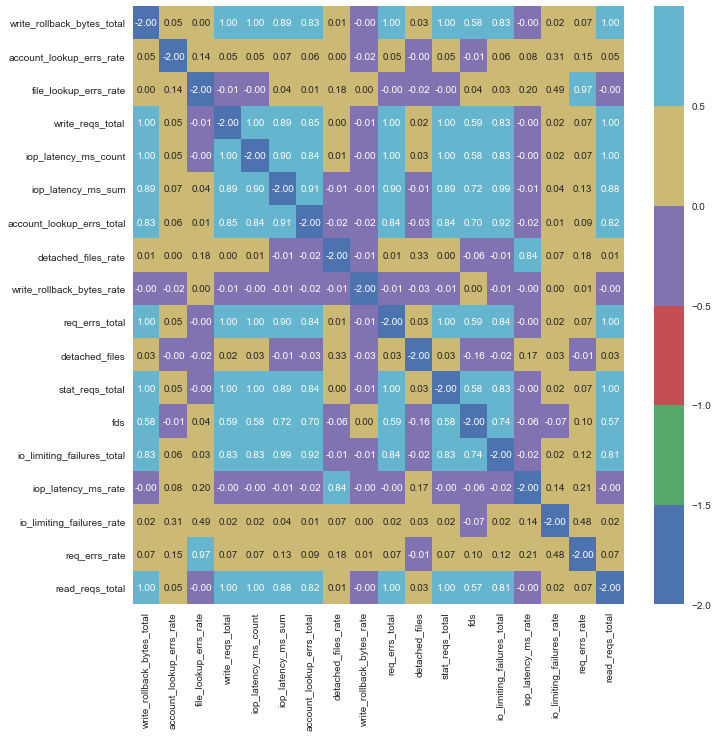

In [9]:
corrs = example_node.corr()
np.fill_diagonal(corrs.values, -2)
fig, ax = plt.subplots(figsize=(11,11))
sns.heatmap(corrs, annot=True, fmt=".2f", cmap=sns.color_palette("deep"), ax=ax)

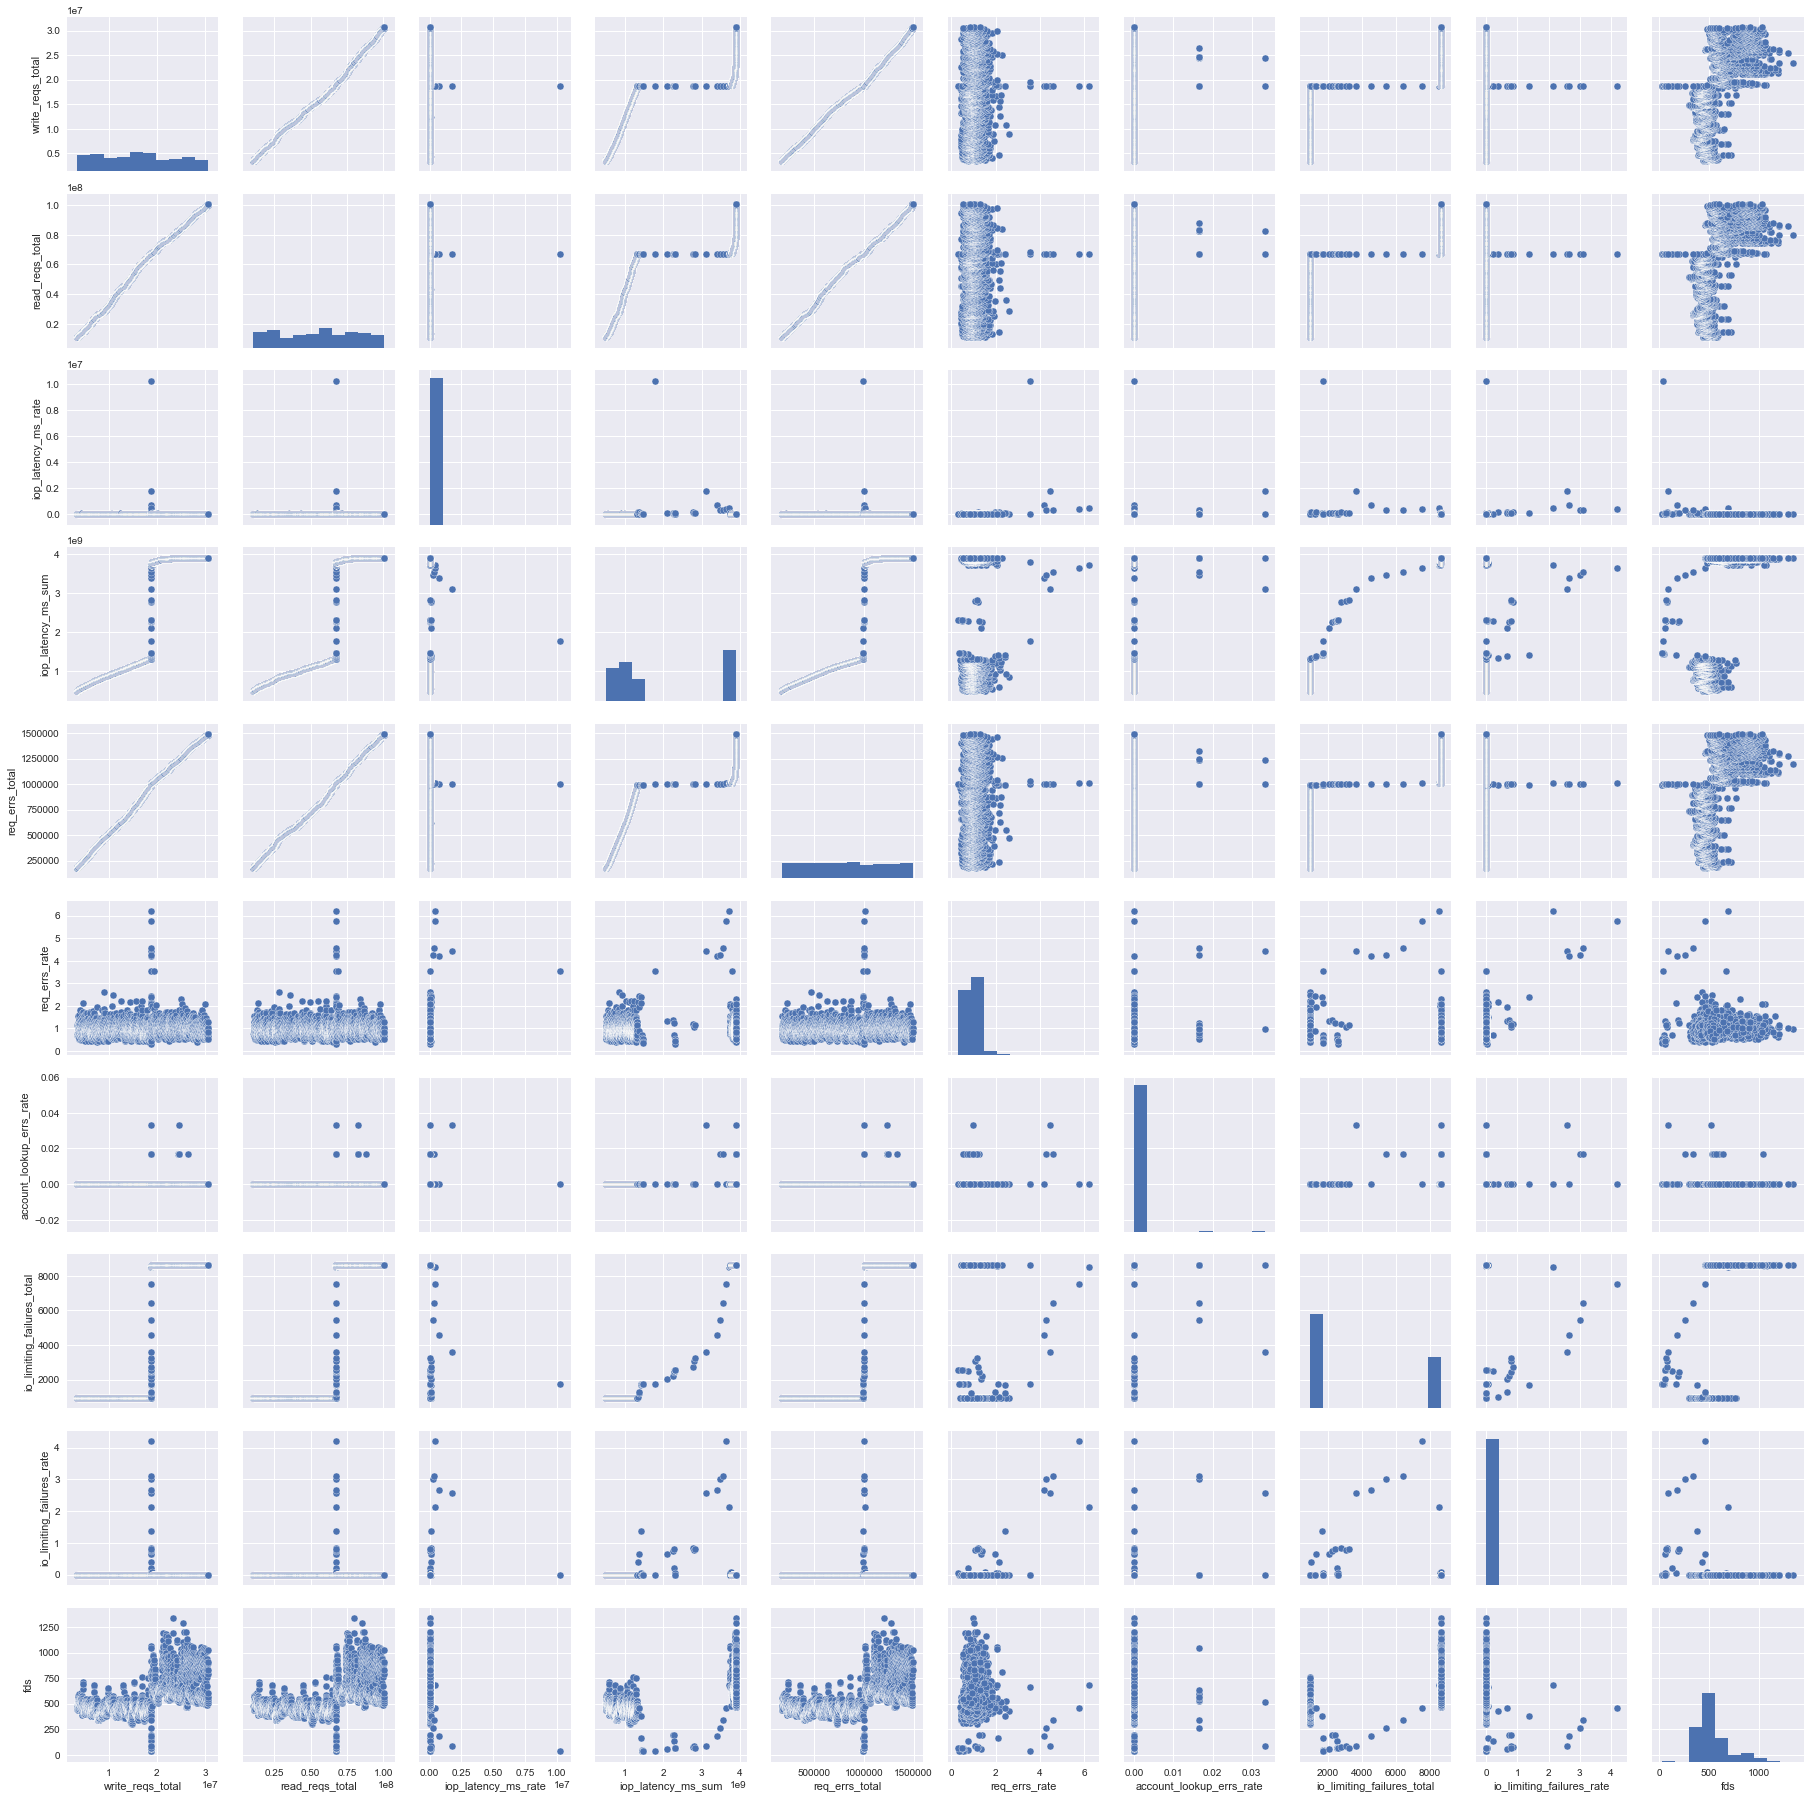

In [11]:
key_cols = ['write_reqs_total',
            'read_reqs_total',
            'iop_latency_ms_rate',
            'iop_latency_ms_sum',
            'req_errs_total',
            'req_errs_rate',
            'account_lookup_errs_rate',
            'io_limiting_failures_total',
            'io_limiting_failures_rate',
            'fds']
sns.pairplot(example_node[key_cols])

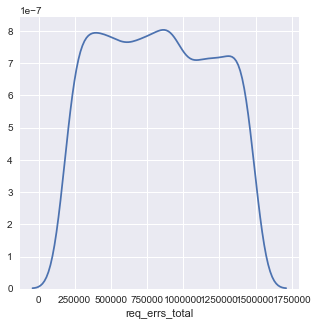

In [12]:
plt.rcParams['figure.figsize']=(5, 5)
sns.distplot(example_node['req_errs_total'], hist=False)

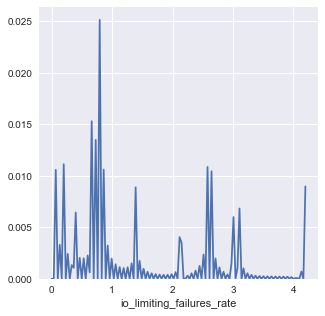

In [13]:
sns.distplot(example_node['io_limiting_failures_rate'], hist=False)

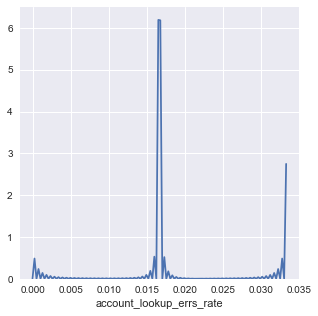

In [14]:
sns.distplot(example_node['account_lookup_errs_rate'], hist=False)

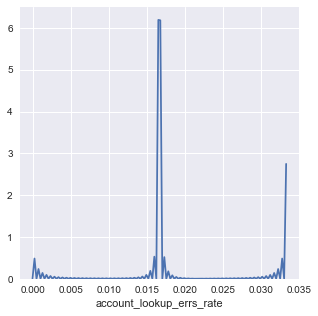

In [15]:
sns.distplot(example_node['account_lookup_errs_rate'], hist=False)

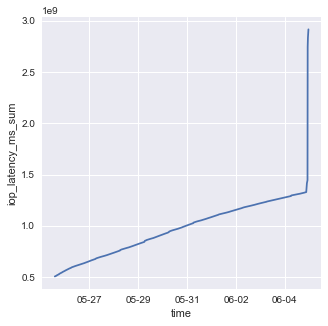

In [16]:
example_node = total[total['instance'] == instances[11]]
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%m-%d"))
plt.plot(example_node['time'], example_node['iop_latency_ms_sum'])
plt.xlabel('time')
plt.ylabel('iop_latency_ms_sum')
plt.show()

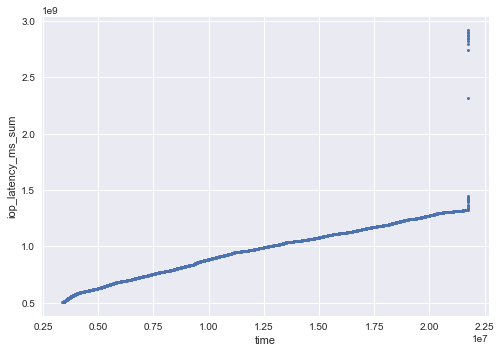

In [17]:
plt.style.use('seaborn')
plt.plot(example_node['write_reqs_total'], example_node['iop_latency_ms_sum'], linestyle='none', marker='o',
         markersize=3)
plt.xlabel('time')
plt.ylabel('iop_latency_ms_sum')
plt.show()

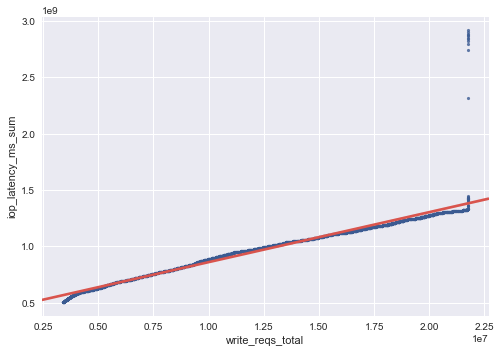

In [18]:
sns.regplot(x='write_reqs_total', y='iop_latency_ms_sum', data=example_node,
            scatter_kws={"color": sns.xkcd_rgb["denim blue"], "s": 10}, line_kws={"color": sns.xkcd_rgb["pale red"]})

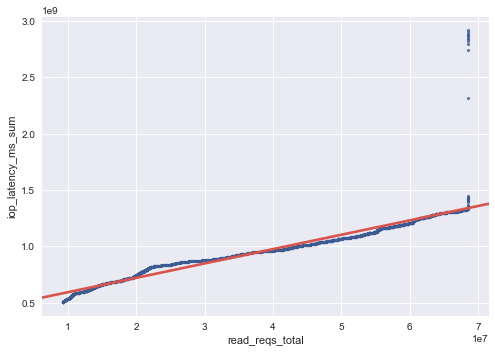

In [19]:
sns.regplot(x='read_reqs_total', y='iop_latency_ms_sum', data=example_node,
            scatter_kws={"color": sns.xkcd_rgb["denim blue"], "s": 10}, line_kws={"color": sns.xkcd_rgb["pale red"]})

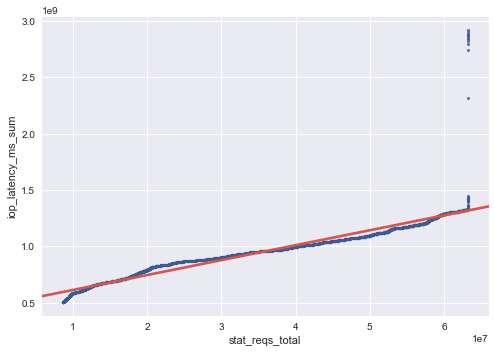

In [20]:
sns.regplot(x='stat_reqs_total', y='iop_latency_ms_sum', data=example_node,
            scatter_kws={"color": sns.xkcd_rgb["denim blue"], "s":10}, line_kws={"color": sns.xkcd_rgb["pale red"]})

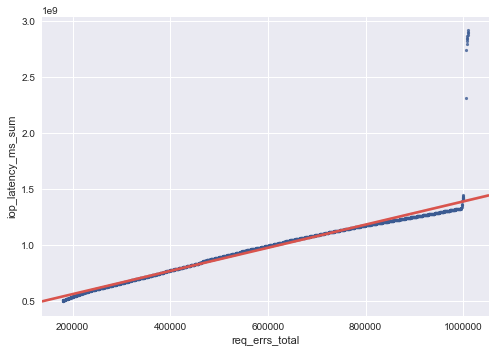

In [21]:
sns.regplot(x='req_errs_total', y='iop_latency_ms_sum', data=example_node,
            scatter_kws={"color": sns.xkcd_rgb["denim blue"], "s":10}, line_kws={"color": sns.xkcd_rgb["pale red"]})

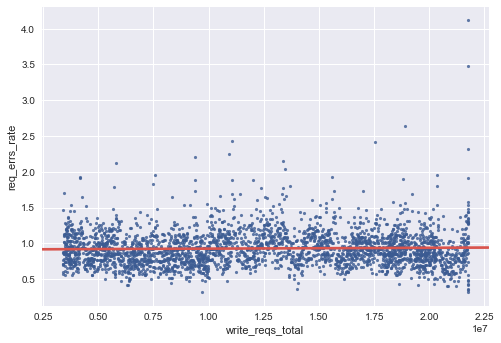

In [22]:
sns.regplot(x='write_reqs_total', y='req_errs_rate', data=example_node,
            scatter_kws={"color": sns.xkcd_rgb["denim blue"], "s":10}, line_kws={"color": sns.xkcd_rgb["pale red"]})

In [23]:
train_data = example_node[-1000:-500]
test_data = example_node[-500:]

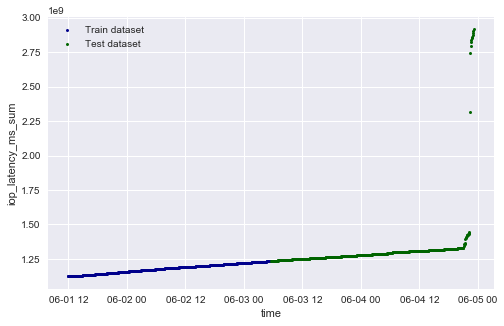

In [24]:
fig, ax = plt.subplots(figsize=(8, 5))
train_line, = plt.plot(train_data['time'], train_data['iop_latency_ms_sum'],
                      linestyle='none', marker='o', color='darkblue',
                      markersize=3)
test_line, = plt.plot(test_data['time'], test_data['iop_latency_ms_sum'],
                      linestyle='none', marker='o', color='darkgreen',
                      markersize=3)
plt.xlabel('time')
plt.ylabel('iop_latency_ms_sum')
plt.legend([train_line, test_line], ['Train dataset', 'Test dataset'])
plt.show()

In [67]:
predictors = [
    'write_reqs_total',
    'read_reqs_total',
    'write_rollback_bytes_total',
    'stat_reqs_total',
    'req_errs_total',
]

regression_model = linear_model.Lasso()
regression_model.fit(train_data[predictors], train_data['iop_latency_ms_sum'])

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [26]:
test_data['iop_latency_ms_predict'] = regression_model.predict(test_data[predictors])
test_data['upper_border'] = test_data['iop_latency_ms_predict'] + train_data['iop_latency_ms_sum'].std()

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [27]:
def detect_anomaly(row):
    if row['upper_border'] < row['iop_latency_ms_sum']:
        return 1
    
    return 0

test_data['is_anomaly'] = test_data.apply(lambda row: detect_anomaly(row), axis=1)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [28]:
normal_data = test_data[test_data['is_anomaly'] == 0]
anomaly_data = test_data[test_data['is_anomaly'] == 1]

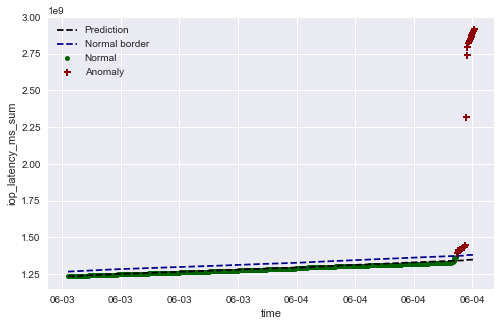

In [29]:
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
normal_dots, = plt.plot(normal_data['time'], normal_data['iop_latency_ms_sum'],
                        linestyle='none', marker='o', color='darkgreen',
                        markersize=5)
anomaly_dots, = plt.plot(anomaly_data['time'], anomaly_data['iop_latency_ms_sum'],
                         linestyle='none', marker='P', color='darkred',
                         markersize=7)
predict_line, = plt.plot(test_data['time'], test_data['iop_latency_ms_predict'],
                         linestyle='--', color='black')
upper_border, = plt.plot(test_data['time'], test_data['upper_border'],
                         linestyle='--', color='darkblue')
plt.xlabel('time')
plt.ylabel('iop_latency_ms_sum')
plt.legend([predict_line, upper_border, normal_dots, anomaly_dots], ['Prediction', 'Normal border', 'Normal',
                                                                     'Anomaly'])
plt.show()

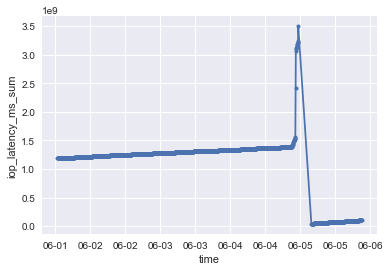

In [57]:
example_node = total[total['instance'] == instances[3]][2000:3200]
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%m-%d"))
plt.plot(example_node['time'], example_node['iop_latency_ms_sum'], marker='o', markersize=4)
plt.xlabel('time')
plt.ylabel('iop_latency_ms_sum')
plt.show()

In [58]:
train_data = example_node[:700]
test_data = example_node[700:]

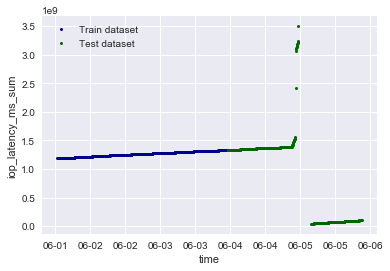

In [59]:
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%m-%d"))
train_line, = plt.plot(train_data['time'], train_data['iop_latency_ms_sum'],
                      linestyle='none', marker='o', color='darkblue',
                      markersize=3)
test_line, = plt.plot(test_data['time'], test_data['iop_latency_ms_sum'],
                      linestyle='none', marker='o', color='darkgreen',
                      markersize=3)
plt.xlabel('time')
plt.ylabel('iop_latency_ms_sum')
plt.legend([train_line, test_line], ['Train dataset', 'Test dataset'])
plt.show()

In [69]:
predictors = [
    'write_reqs_total',
    'read_reqs_total',
    'write_rollback_bytes_total',
    'stat_reqs_total',
    'req_errs_total',
]

regression_model = linear_model.Lasso()
regression_model.fit(train_data[predictors], train_data['iop_latency_ms_sum'])

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [70]:
test_data['iop_latency_ms_predict'] = regression_model.predict(test_data[predictors])
test_data['upper_border'] = test_data['iop_latency_ms_predict'] + train_data['iop_latency_ms_sum'].std()
test_data['is_anomaly'] = test_data.apply(lambda row: detect_anomaly(row), axis=1)
normal_data = test_data[test_data['is_anomaly'] == 0]
anomaly_data = test_data[test_data['is_anomaly'] == 1]

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

In [80]:
last_anomaly_index = anomaly_data.index.max()
before_anomaly_indexes = [x for x in normal_data.index if x <= last_anomaly_index]
after_anomaly_indexes = [x for x in normal_data.index if x > last_anomaly_index]

before_anomaly_data = test_data.ix[before_anomaly_indexes]
after_anomaly_data = test_data.ix[after_anomaly_indexes]

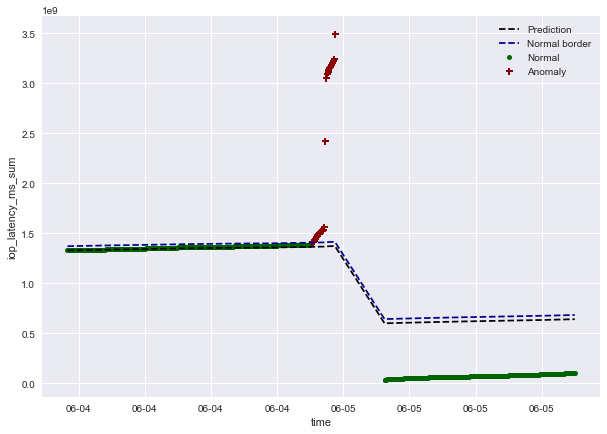

In [71]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
normal_dots, = plt.plot(normal_data['time'], normal_data['iop_latency_ms_sum'],
                        linestyle='none', marker='o', color='darkgreen',
                        markersize=5)
anomaly_dots, = plt.plot(anomaly_data['time'], anomaly_data['iop_latency_ms_sum'],
                         linestyle='none', marker='P', color='darkred',
                         markersize=7)
predict_line, = plt.plot(test_data['time'], test_data['iop_latency_ms_predict'],
                         linestyle='--', color='black')
upper_border, = plt.plot(test_data['time'], test_data['upper_border'],
                         linestyle='--', color='darkblue')
plt.xlabel('time')
plt.ylabel('iop_latency_ms_sum')
plt.legend([predict_line, upper_border, normal_dots, anomaly_dots], ['Prediction', 'Normal border', 'Normal',
                                                                     'Anomaly'])
plt.show()

In [75]:
last_anomaly_index = anomaly_data.index.max()
after_anomaly_indexes = [x for x in normal_data.index if x > last_anomaly_index]
after_anomaly_data = test_data.ix[after_anomaly_indexes]

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


In [78]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 54199 to 64933
Data columns (total 23 columns):
time                          500 non-null datetime64[ns]
write_rollback_bytes_total    500 non-null int64
instance                      500 non-null object
account_lookup_errs_rate      500 non-null float64
file_lookup_errs_rate         500 non-null float64
write_reqs_total              500 non-null int64
iop_latency_ms_count          500 non-null int64
iop_latency_ms_sum            500 non-null float64
account_lookup_errs_total     500 non-null int64
detached_files_rate           500 non-null float64
write_rollback_bytes_rate     500 non-null float64
req_errs_total                500 non-null int64
detached_files                500 non-null int64
stat_reqs_total               500 non-null int64
fds                           500 non-null int64
io_limiting_failures_total    500 non-null int64
iop_latency_ms_rate           500 non-null float64
io_limiting_failures_rate     500 

In [ ]:
sns.pairplot(example_node)

In [ ]:
sns.jointplot(y='detached_files_rate', x='fds', data=example_node, kind='reg')

In [ ]:
sns.distplot(example_node['write_rollback_bytes_total'], hist=False)